# Hyperparameter tuning for simple ML models

1. Gridsearch approach
2. Bayesian approaches - custom loop, and BayesSearchCV from skopt

## Data Preparation

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import warnings
# silence warnings for parameter options we have already tried, useful when iterating
warnings.filterwarnings("ignore")

d = load_wine()
X, y = d.data, d.target

# X = X[:, np.newaxis, 2]
# X = np.array(X.iloc[:, 0]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0
)

print(X_train[:1])
print(y_train[:1])

def plot(x,y, title="Scores over n iterations"):
    plt.plot(x,y)
    plt.ylabel('Mean Test Score')
    plt.title(title)
    plt.grid(True)
    plt.show()

[[1.369e+01 3.260e+00 2.540e+00 2.000e+01 1.070e+02 1.830e+00 5.600e-01
  5.000e-01 8.000e-01 5.880e+00 9.600e-01 1.820e+00 6.800e+02]]
[2]


## BayesSearchCV

In [4]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [10,4]


def bayes_search_cv_example():
    model = GradientBoostingClassifier(random_state=0, n_estimators=50)
    
    # Param n_iter: Number of parameter settings that are sampled; 
    # tradeoff between runtime vs quality of the solution.
    # Param cv: Number of cross validation folds, default is 3.
    # print(sklearn.metrics.SCORERS.keys())
    
    opt = BayesSearchCV(
        model,
        {
            'learning_rate':list(np.arange(0.1,0.4,0.1)),
            'n_estimators': list(range(50,200,50)),
            'min_samples_split': list(range(2,10,2))
        },
        n_iter=10,
        cv=5,
        n_jobs=-1,
        pre_dispatch="2*n_jobs",
        scoring='r2',
        random_state = 0
    )
    
    opt.fit(X_train, y_train)

    x = pd.DataFrame(opt.cv_results_)['mean_test_score'].index
    y = pd.DataFrame(opt.cv_results_)['mean_test_score']
    plot(x,y)

    print("Best Validation Score:", opt.best_score_)
    print("Test Score:", opt.score(X_test, y_test))

## Bayes custom loop

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.space import Real, Integer
from skopt import gp_minimize

import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [10,4]

def bayes_loop_example():
    model = GradientBoostingClassifier(random_state=0, n_estimators=50)

    space = [
        Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
        Integer(20, 50, name='n_estimators'),
        Integer(2, 8, name='min_samples_split')
    ]

    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)

        return -np.mean(cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1,
                                        scoring="neg_mean_absolute_error")) 

    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    plot_convergence(res_gp)

    print("Best Parameters", res_gp.x)
    print("Best Score", res_gp.fun)

## GridSearchCV

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

def grid_search_example():
    model = GradientBoostingClassifier(random_state=0, n_estimators=50)
    
    pg = {
        'learning_rate':list(np.arange(0.1,0.4,0.1)),
        'n_estimators': list(range(50,200,50)),
        'min_samples_split': list(range(2,10,2))
    }
    
    opt = GridSearchCV(estimator=model, param_grid=pg, scoring='r2', cv=5)
    opt.fit(X_train, y_train)
    
    df = pd.DataFrame(opt.cv_results_)
    
    x = df['mean_test_score'].index
    y = df['mean_test_score']
    plot(x,y)

    print("Validation Score:", opt.best_score_)
    print("Test Score:", opt.score(X_test, y_test))


## Execution and Testing

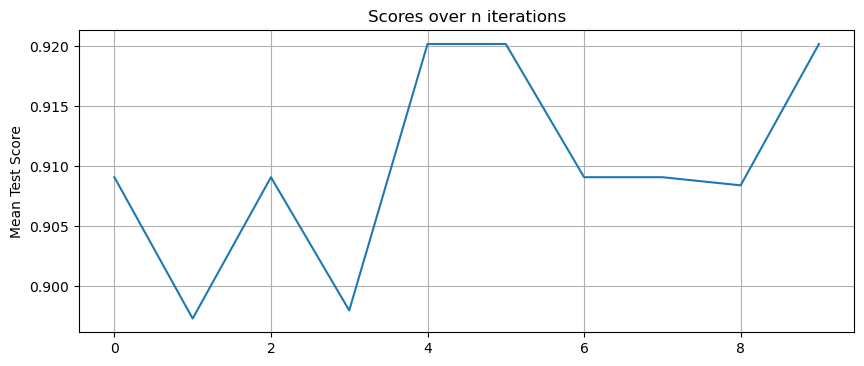

Best Validation Score: 0.920187134502924
Test Score: 0.9451219512195121
7.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%timeit -n1 -r1 bayes_search_cv_example()

Best Parameters [0.3306761856602668, 50, 8]
Best Score 0.04890661938534279
9.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


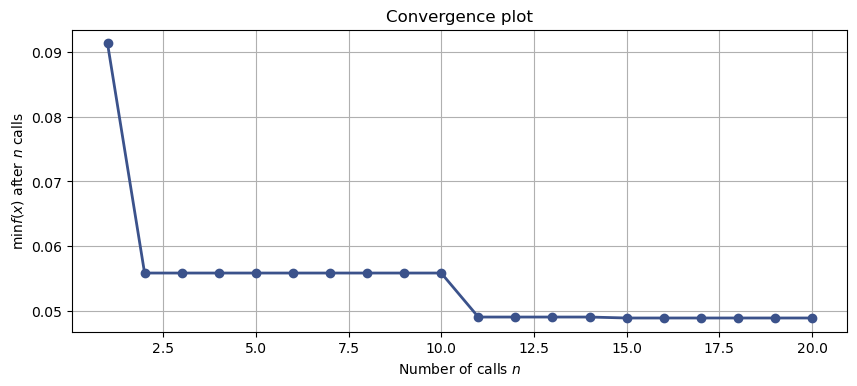

In [8]:
%timeit -n1 -r1 bayes_loop_example()

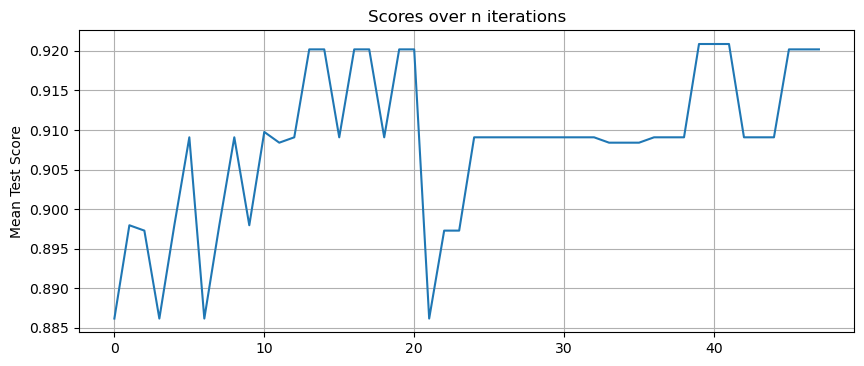

Validation Score: 0.9208654970760234
Test Score: 0.8902439024390244
45.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%timeit -n1 -r1 grid_search_example()